Part of Assignment from 42028 Deep Learning and Convolutional Neural Network

## CNN architecture for Image classification

### Import the required libraries

In [0]:
%tensorflow_version 1.x
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
np.random.seed(1)
tf.compat.v1.set_random_seed(1)
from tensorflow import keras
from keras.preprocessing import image
from keras import layers
from keras import Model
from keras.optimizers import RMSprop
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras.models import load_model
from keras.applications import VGG16
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

### Conect to Google Drive and Change to directory to access the Dataset

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


***Note: This code might require changes...***


In [0]:
cd /content/gdrive/My Drive/Assignment-2/dataset

/content/gdrive/My Drive/Assignment-2/dataset


### Data Preparation (Data Augmentation)

In [0]:
train_dir = '/content/gdrive/My Drive/Assignment-2/dataset/Training'
val_dir = '/content/gdrive/My Drive/Assignment-2/dataset/Validation'
test_dir = '/content/gdrive/My Drive/Assignment-2/dataset/Testing'

size=(256,256)    #All images wii be resized to 256x256
scale= 1./255     #All images will be rescaled by 1./255

train_datagen = ImageDataGenerator(rescale=scale,
                                   rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.5,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=scale)
test_datagen = ImageDataGenerator(rescale=scale)

# Flow training images in batches of 25 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=size, 
        batch_size=25,
        class_mode='sparse') # Since we have categorical label, we use sparse

# Flow validation images in batches of 15 using train_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        val_dir,  # This is the source directory for validation images
        target_size=size,  
        batch_size=15,
        class_mode='sparse')

# Flow test images in batches of 15 using train_datagen generator
test_generator = test_datagen.flow_from_directory(
        test_dir,  # This is the source directory for test images
        target_size=size,
        batch_size=15,
        class_mode='sparse')

Found 675 images belonging to 4 classes.
Found 225 images belonging to 4 classes.
Found 225 images belonging to 4 classes.


Display an image after data augmentation process

Indexes info: 0.0(Cloudy), 1.0(Rain), 2.0(Shine), 3.0(Sunrise)
Label index: 3.000


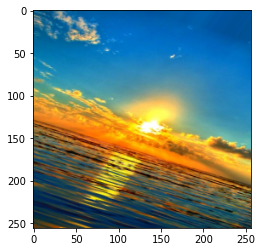

In [0]:
x,y = train_generator.next()

image = x[7]
label = y[7]
print('Indexes info: 0.0(Cloudy), 1.0(Rain), 2.0(Shine), 3.0(Sunrise)')
print ('Label index: %.3f' % label)
plt.imshow(image)
plt.show()

### Create the checkpoint 
Save model during the training model and will be used when do the test with an image classification

In [0]:
#For Original Baseline
checkpoint=ModelCheckpoint("vgg16_1.h5", monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
chck_ponints = [checkpoint]

### Original Baseline Architecture

I tried three base networks to see which the most suitable network for weather classification dataset. The three networks are VGG16, AlexaNet, and Resnet50. From the experiment that I did, **I use the baseline architecture of VGG16 for the data classification task** as the performance and accuracy that produced by this model were quite good.

#### Original architecture (VGG16)

In [0]:
ori_base = VGG16(weights='imagenet',include_top=False, input_shape=(256,256,3))

# Load the CONV layers of VGG16 model and add the FC layers
VGG16model = models.Sequential()
VGG16model.add(ori_base)
VGG16model.add(layers.Flatten())
VGG16model.add(layers.Dense(256, activation='relu'))
VGG16model.add(layers.Dense(256, activation='relu'))
VGG16model.add(layers.Dense(4, activation='sigmoid'))

#### Display the VGG16 Network and use a Transfer Learning

In [0]:
ori_base.summary()
VGG16model.summary()

#Freeze the first 10 layers and train the rest of the layers (8 layers) with the weather dataset
for layer in ori_base.layers[:-8]:
    layer.trainable = False
 
# Check the trainable status of the individual layers
for layer in ori_base.layers:
    print(layer, layer.trainable)

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

#### Compile the model

In [0]:
VGG16model.compile(loss='sparse_categorical_crossentropy', #because we have multiple classes, we use 'sparse_categorical_crossentropy'
                   optimizer=optimizers.RMSprop(lr=1e-5), 
                   metrics=['acc'])

#### Fit the model

***Note: This process might take around 6 hours...***

In [0]:
# Train the model
VGG16_H = VGG16model.fit_generator(
      train_generator,
      steps_per_epoch=27,  #steps = 675 images/25 batch_size
      epochs=30,
      validation_data=validation_generator,
      validation_steps=15,  # steps= 225 images/15 batch_size
      callbacks = chck_ponints,
      verbose=2)

Epoch 1/30
 - 698s - loss: 1.1879 - acc: 0.4919 - val_loss: 0.9081 - val_acc: 0.7067
Epoch 2/30
 - 688s - loss: 0.5860 - acc: 0.7822 - val_loss: 0.2662 - val_acc: 0.9067
Epoch 3/30
 - 689s - loss: 0.3679 - acc: 0.8711 - val_loss: 0.2617 - val_acc: 0.8800
Epoch 4/30
 - 689s - loss: 0.2936 - acc: 0.9037 - val_loss: 1.3333 - val_acc: 0.8356
Epoch 5/30
 - 687s - loss: 0.2507 - acc: 0.9096 - val_loss: 0.1568 - val_acc: 0.9422
Epoch 6/30
 - 689s - loss: 0.2173 - acc: 0.9185 - val_loss: 0.2609 - val_acc: 0.9111
Epoch 7/30
 - 685s - loss: 0.1954 - acc: 0.9230 - val_loss: 0.3531 - val_acc: 0.9244
Epoch 8/30
 - 688s - loss: 0.1691 - acc: 0.9437 - val_loss: 0.0868 - val_acc: 0.9556
Epoch 9/30
 - 687s - loss: 0.1739 - acc: 0.9363 - val_loss: 0.8309 - val_acc: 0.8400
Epoch 10/30
 - 684s - loss: 0.1682 - acc: 0.9363 - val_loss: 0.0220 - val_acc: 0.9600
Epoch 11/30
 - 683s - loss: 0.1330 - acc: 0.9467 - val_loss: 0.2868 - val_acc: 0.9378
Epoch 12/30
 - 683s - loss: 0.1142 - acc: 0.9585 - val_loss: 0.

#### Evaluate the model with test dataset

In [0]:
loss, accuracy = VGG16model.evaluate_generator(test_generator,steps=30)
print('Test Loss: %.3f' % loss)
print('Test Accuracy: %.3f' % accuracy)

Test Loss: 0.396
Test Accuracy: 0.956


#### Plot the performance of model
The training and validation, accuracy and loss

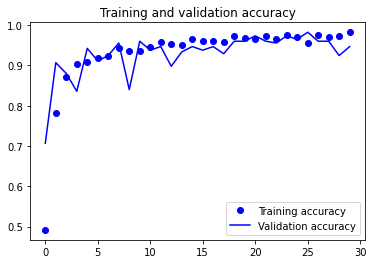

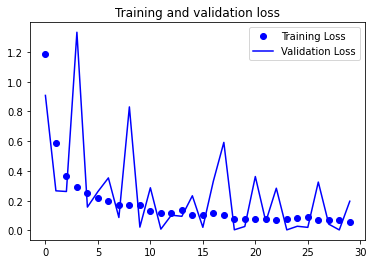

In [0]:
import matplotlib.pyplot as plt
acc = VGG16_H.history['acc']
val_acc = VGG16_H.history['val_acc']
loss = VGG16_H.history['loss']
val_loss = VGG16_H.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### Display the image classification result with the model

Prediction info: [Cloudy, Rain, Shine, Sunrise]
Predicted :  [[0. 0. 0. 1.]]


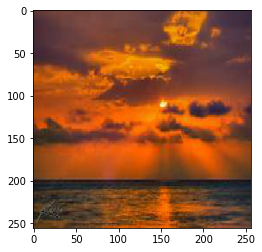

In [0]:
from keras.preprocessing import image

#load the image
img_path = '/content/gdrive/My Drive/Assignment-2/sunrise284.jpg'
img = image.load_img(img_path, target_size=(256, 256))
ax1 = plt.imshow(img)
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)

#load the model
model = load_model("vgg16_1.h5")

#make a prediction for the image
prediction = model.predict(img)

#print the result
print('Prediction info: [Cloudy, Rain, Shine, Sunrise]')
print('Predicted : ', prediction)

### Customized Baseline Architecture

#### Customized architecture (VGG16)

In [0]:
base = VGG16(weights='imagenet',include_top=False, input_shape=(256,256,3))

#Remove the last 4 layers in the VGG16
base.layers.pop()
base.layers.pop()
base.layers.pop()
base.layers.pop()

# Load the CONV layers of VGG16 model and add the FC layers
C_VGG16model = models.Sequential()
C_VGG16model.add(base)
C_VGG16model.add(layers.Dropout(0.5)) #add the dropout layer to avoid overfitting
C_VGG16model.add(layers.Flatten())
C_VGG16model.add(layers.Dense(256, activation='relu'))
C_VGG16model.add(layers.Dense(4, activation='sigmoid'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

58892288/58889256 [==============================] - 2s 0us/step


#### Display the VGG16 Network and use a Transfer Learning

In [0]:
base.summary()
C_VGG16model.summary()
for layer in base.layers[:-8]:
    layer.trainable = False
 
# Check the trainable status of the individual layers
for layer in base.layers:
    print(layer, layer.trainable)

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

#### Compile the model

In [0]:
C_VGG16model.compile(loss='sparse_categorical_crossentropy', #because we have multiple classes, we use 'sparse_categorical_crossentropy'
                    optimizer=optimizers.RMSprop(lr=1e-5),
                    metrics=['acc'])

#### Fit the model

***Note: This process might take around 6 hours...***

In [0]:
# Train the model
C_VGG16_H = C_VGG16model.fit_generator(
      train_generator,
      steps_per_epoch=27,  #steps = 675 images/25 batch_size
      epochs=20,
      validation_data=validation_generator,
      validation_steps=15,  # steps= 225 images/15 batch_size
      verbose=2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/20
 - 909s - loss: 1.3359 - acc: 0.3304 - val_loss: 1.1804 - val_acc: 0.4222
Epoch 2/20
 - 881s - loss: 1.1478 - acc: 0.5111 - val_loss: 0.9091 - val_acc: 0.7200
Epoch 3/20
 - 880s - loss: 0.7786 - acc: 0.7244 - val_loss: 0.4278 - val_acc: 0.8622
Epoch 4/20
 - 874s - loss: 0.5451 - acc: 0.7926 - val_loss: 0.2947 - val_acc: 0.9111
Epoch 5/20
 - 882s - loss: 0.4395 - acc: 0.8356 - val_loss: 0.2678 - val_acc: 0.8667
Epoch 6/20
 - 881s - loss: 0.3313 - acc: 0.8652 - val_loss: 0.5309 - val_acc: 0.8267
Epoch 7/20
 - 892s - loss: 0.3337 - acc: 0.8622 - val_loss: 0.2240 - val_acc: 0.9111
Epoch 8/20
 - 895s - loss: 0.2701 - acc: 0.8978 - val_loss: 0.1030 - val_acc: 0.9600
Epoch 9/20
 - 879s - loss: 0.2355 - acc: 0.9067 - val_loss: 0.7327 - val_acc: 0.8800
Epoch 10/20
 - 879s - loss: 0.2703 - acc: 0.8978 - val_loss: 0.0144 - val_acc: 0.9511
Epoch 11/20
 - 877s - loss: 0.2240 - acc: 0.9244 - val

#### Evaluate the model with test dataset

In [0]:
loss1, accuracy1 = C_VGG16model.evaluate_generator(test_generator,steps=20)
print('Test Loss: %.3f' % loss1)
print('Test Accuracy: %.3f' % accuracy1)

Test Loss: 0.015
Test Accuracy: 0.970


#### Plot the performance of model
The training and validation, accuracy and loss

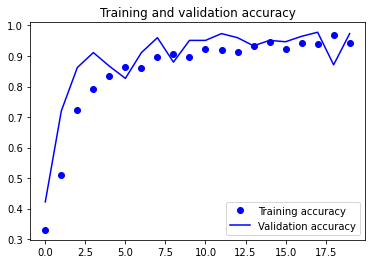

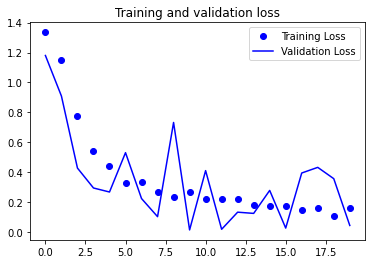

In [0]:
import matplotlib.pyplot as plt
acc = C_VGG16_H.history['acc']
val_acc = C_VGG16_H.history['val_acc']
loss = C_VGG16_H.history['loss']
val_loss = C_VGG16_H.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()